# Neural Network Model Trainer 
This notebook is used to define a Deep Learning model for any application and save its parameters. This is done in steps:
1. Defining input data and output data
2. Splitting into train, dev/validation and test sets
3. Defining initial hyperparameters
4. Training an initial model
5. Testing the model on dev/validation sets and tuning hyperparameters
6. Saving the final model parameters

**Note:** Only code that is enclosed in the following format can be edited:

In [1]:
#-------------------------------------#
#You can edit the code here
#-------------------------------------#

Importing dependencies:

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import pickle
import time

Importing neural network modeler:

In [3]:
from neural_network import initialize_parameters, dropout_regularize, forward_propagate, compute_cost 
from neural_network import model_train, predict, compute_accuracy, compute_precision

## 1) Define Input and Output Data:

Format the Dataset as required:

In [4]:
#-----------------------------------------------------
Data = np.load("tomato_data_1000yes_2250no.npy")
Data = Data.T
Data = pd.DataFrame(Data)
Dataset = Data.sample(frac = 1) #Shuffles the dataset
Dataset = Dataset.to_numpy() #Converts to numpy array
Dataset = Dataset.T
#-----------------------------------------------------

Define X (input) and Y (output): 

In [5]:
#--------------------------------------------------------
X = np.array(Dataset[1:])
X = X.reshape(X.shape[-2], X.shape[-1])

Y = np.array([Dataset[0]])
Y = Y.reshape(Y.shape[-2], Y.shape[-1])
#--------------------------------------------------------

m = X.shape[1]
X.shape, Y.shape

((196608, 3250), (1, 3250))

## 2) Split into Train, Dev and Test sets:

Define the splitting ratios (Sum of ratios should be 1 for model to work):

In [6]:
#-------------------------------
train = 0.8
dev = 0.1
test = 0.1
#-------------------------------

train_length = round(train*m)
dev_length = round(dev*m)

Forming the splits:

In [7]:
X_train, X_dev, X_test = np.split(X, [train_length, dev_length + train_length], axis = 1)
Y_train, Y_dev, Y_test = np.split(Y, [train_length, dev_length + train_length], axis = 1)

train_length, dev_length

(2600, 325)

Normalizing:

In [8]:
mean = np.mean(X_train, axis = 1, keepdims = True)
std = np.std(X_train, axis = 1, keepdims = True)
X_train = (X_train - mean)/std
X_dev = (X_dev - mean)/std
X_test = (X_test - mean)/std

Convert Data into Tensors:

In [9]:
X_train = tf.constant(X_train)
X_dev = tf.constant(X_dev)
X_test = tf.constant(X_test)
Y_train = tf.constant(Y_train)
Y_dev = tf.constant(Y_dev)
Y_test = tf.constant(Y_test)

## 3) Define Hyperparameters:

In [10]:
#---------------------------------------------------------
num_layers = 6 #Number of layers in the neural network (excluding input layer)

num_nodes = [X.shape[0], 5, 10, 20, 10, 5, Y.shape[0]]

learning_rate = 0.003
num_epochs = 500
print_cost = True
print_cost_per_epoch = 1
initializer = tf.keras.initializers.GlorotNormal()

#Activation functions:
linear = tf.keras.activations.linear
sigmoid = tf.keras.activations.sigmoid
relu = tf.keras.activations.relu

#----------------------------------------------------#
activations = {}
for i in range(1, num_layers):
    activations['L' + str(i)] = relu
activations['L' + str(num_layers)] = sigmoid
#----------------------------------------------------#

dropout_probs = [1, 0.8, 0.8, 0.8, 0.8, 0.8, 1]
    
#activations now are (linear-->relu)x5 + linear-->sigmoid

loss_function = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)
accuracy = tf.keras.metrics.BinaryAccuracy()

## 4) Train a Model from most recent Hyperparameters:

Cost at epoch 500  =  0.017013711854815483
Time taken for last  1  epochs =  0.51  seconds


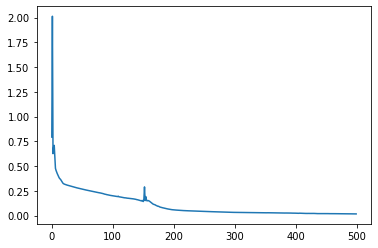

In [31]:
params, cost = model_train(X_train, Y_train, num_layers, num_nodes, num_epochs, dropout_probs, initializer, activations, 
                           loss_function, optimizer, print_cost, print_cost_per_epoch)

In [32]:
params['mean'] = mean
params['std'] = std
params['activations'] = activations
params['num_layers'] = num_layers

## 5) Model Testing:

Generate prediction tensors on train set and dev set:

In [12]:
train_prediction = predict(X_train, params, normalize = False)
dev_prediction = predict(X_dev, params, normalize = False)
test_prediction = predict(X_test, params, normalize = False)

Compute Accuracy on train set and dev set:

In [13]:
train_accuracy = compute_accuracy(train_prediction, Y_train)
dev_accuracy = compute_accuracy(dev_prediction, Y_dev)
test_accuracy = compute_accuracy(test_prediction, Y_test)

print("Train set accuracy = ", train_accuracy, "%")
print("Dev set accuracy = ", dev_accuracy, "%")
print("Test set accuracy = ", test_accuracy, "%")

Train set accuracy =  97.6 %
Dev set accuracy =  96.89999999999999 %
Test set accuracy =  98.5 %


Compute Precision on train set and dev set:

In [14]:
train_precision = compute_precision(train_prediction, Y_train)
dev_precision = compute_precision(dev_prediction, Y_dev)
test_precision = compute_precision(test_prediction, Y_test)

print("Train set precision = ", train_precision, "%")
print("Dev set precision = ", dev_precision, "%")
print("Test set precision = ", test_precision, "%")

Train set precision =  95.97 %
Dev set precision =  96.81 %
Test set precision =  98.15 %


## 6) Save Model Parameters:

Saving weights to a binary file:

In [45]:
np.save("iteration_3_weights", params)

Loading weights from a file:

In [16]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

weights = np.load("iteration_3_weights.npy")
weights = weights[()]

# restore np.load for future normal usage
np.load = np_load_old

Precision on imported weights:

In [20]:
train_prediction = predict(X_train, weights, normalize = False)
dev_prediction = predict(X_dev, weights, normalize = False)
test_prediction = predict(X_test, weights, normalize = False)

In [21]:
train_precision = compute_precision(train_prediction, Y_train)
dev_precision = compute_precision(dev_prediction, Y_dev)
test_precision = compute_precision(test_prediction, Y_test)

print("Train set precision = ", train_precision, "%")
print("Dev set precision = ", dev_precision, "%")
print("Test set precision = ", test_precision, "%")

Train set precision =  95.97 %
Dev set precision =  96.81 %
Test set precision =  98.15 %


Precision on full dataset:

In [18]:
X_full = tf.constant(X)
Y_full = tf.constant(Y)

prediction = predict(X_full, weights)

In [19]:
compute_precision(prediction, Y_full)

96.29